<a href="https://colab.research.google.com/github/nidhin-koshy/Notebooks/blob/master/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection
In this module we will look at a credit card transactions dataset, where, of the more than 2.5 lakh entries, less than 500 are fraud transactions, that is less than 0.2% of the total number of transactions. The aim is to device an algorithm that can detect a fraud with high probability (true positive), even at the cost of a higher percentage of false positives. Note that if the aim of a classifier is just to reduce the average error, it might as well declare all samples as non-fraud, and will still have an accuracy of 99.8%.

This is an example of an un-balanced classification task, where the number of samples per class label is not of the same order. In such scenarios, the metric of interest should not be just accuracy, but we need to look at the true positive rate, false positive rate, true negative rate and false negative rate. These four metrics are captured in confusion matrix. We will also have a look at how to obtain receiver operating characteristics (ROC) curves for different classifiers.

## Credit Card transactions data

We look at creditcard transactions data from Europe for two days.

The data was preprocessed (PCA) and we are provided with 28 features, but there is no meaningful description for any feature. Such a processing helps to : 1) project the data on to a smaller dimensional subspace, without loosing much information, and 2) it also helps to hide any user transaction related data. 

Source - https://www.openml.org/d/1597

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import fetch_openml # scikit-learn module to download data from openml.org
cc_trans = fetch_openml(data_id=1597)

In [3]:
print(cc_trans.data.shape)
print(cc_trans.details) # print details of the dataset
print(cc_trans.DESCR) # print more details about the dataset
print(cc_trans.target.shape) #print the number of records and features in the dataset
pd_df = pd.DataFrame(cc_trans.data) #convert the dataset into a pandas dataframe
pd_df['class'] = cc_trans.target.astype('int') # Add the target data into pandas dataframe, and convert class labels to integers
print(pd_df['class'].value_counts())  # print the number of records for each class label
pd_df.head()

(284807, 29)
{'id': '1597', 'name': 'creditcard', 'version': '1', 'format': 'ARFF', 'creator': ['Andrea Dal Pozzolo', 'Olivier Caelen', 'Gianluca Bontempi'], 'upload_date': '2015-06-25T16:52:17', 'licence': 'Public', 'url': 'https://www.openml.org/data/v1/download/1673544/creditcard.arff', 'file_id': '1673544', 'default_target_attribute': 'Class', 'row_id_attribute': 'Time', 'version_label': 'V1_250615', 'tag': ['Classification', 'Creditcard', 'Fraud', 'Unbalanced', 'WebAnalytics2015'], 'visibility': 'public', 'status': 'active', 'processing_date': '2018-10-03 21:50:15', 'md5_checksum': '178bcf9bb1f31a3dfe12d0e577884add'}
**Author**: Andrea Dal Pozzolo, Olivier Caelen and Gianluca Bontempi  
**Source**: Credit card fraud detection - Date 25th of June 2015  
**Please cite**: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM),

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
pd_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.958151e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392438e-15,-7.466538e-16,4.258738e-16,9.020169e-16,5.126845e-16,1.471982e-16,8.042109e-16,5.282450e-16,4.458267e-15,1.426896e-15,1.701640e-15,-3.671606e-16,-1.218152e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


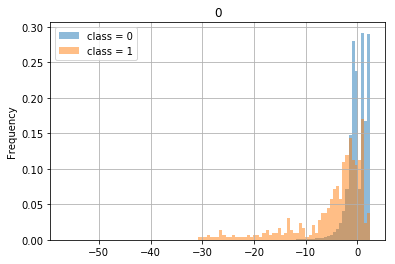

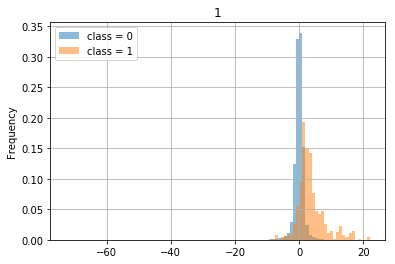

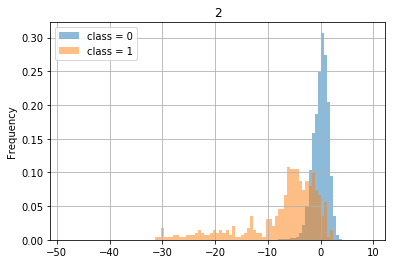

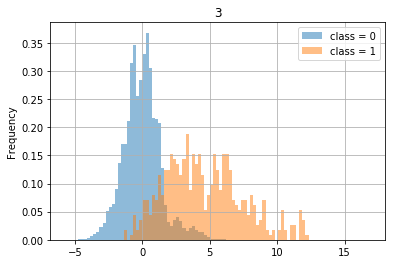

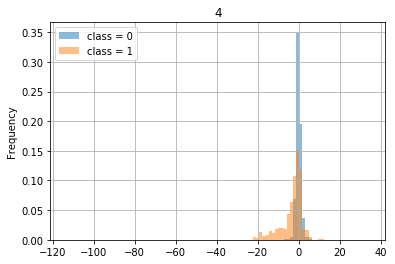

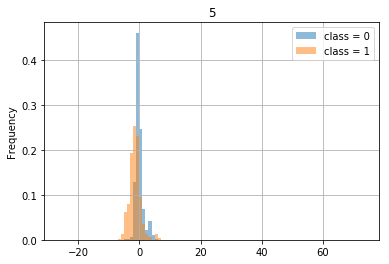

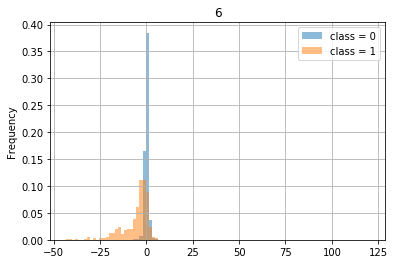

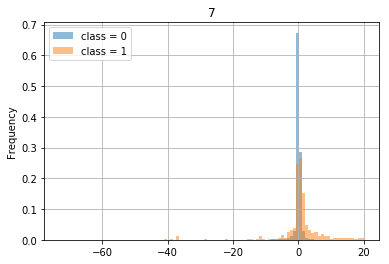

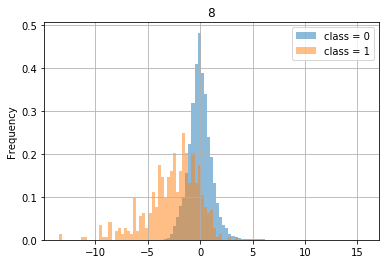

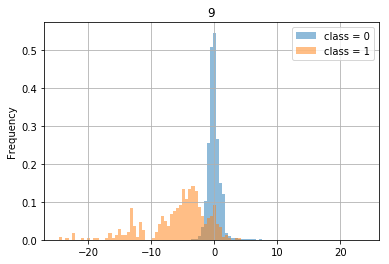

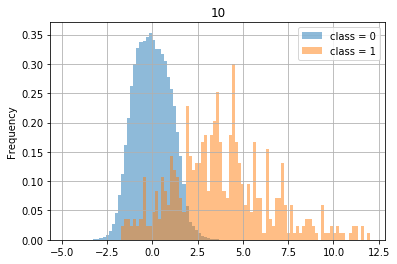

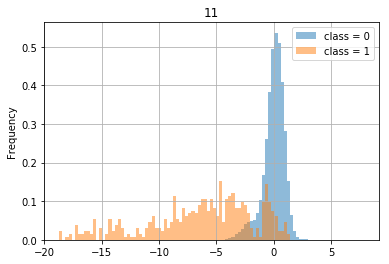

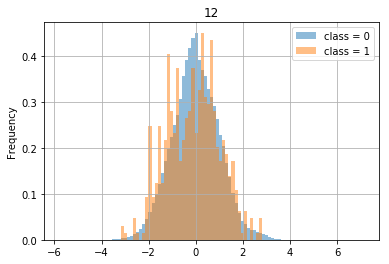

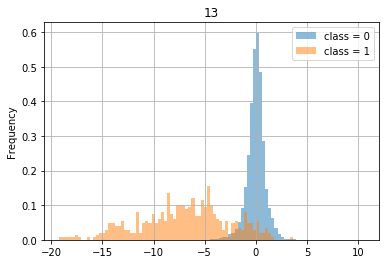

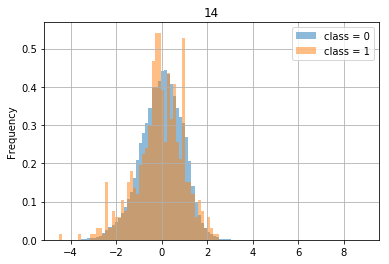

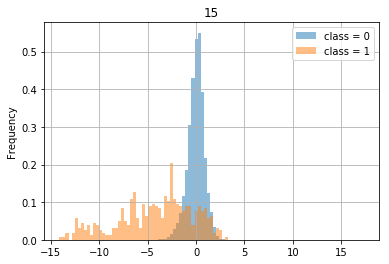

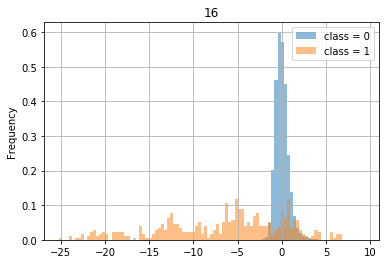

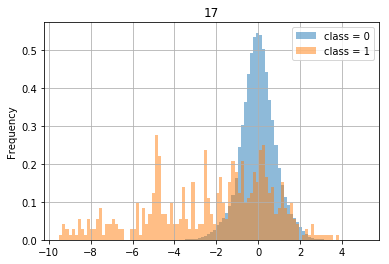

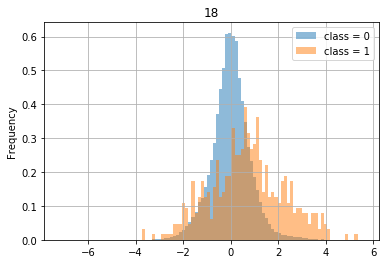

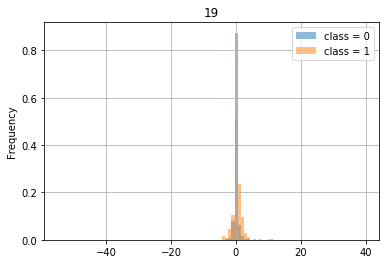

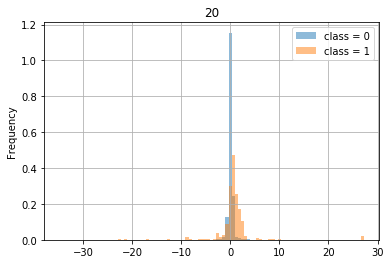

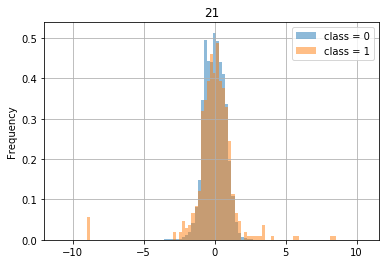

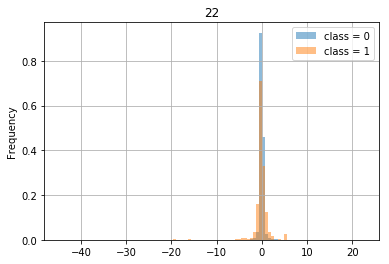

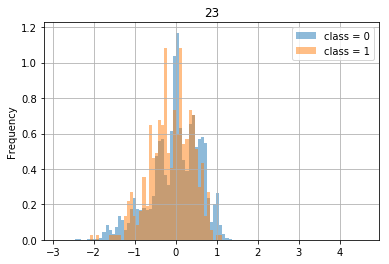

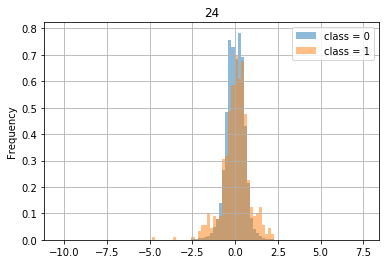

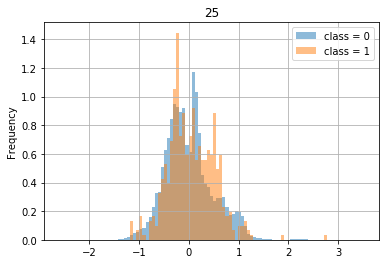

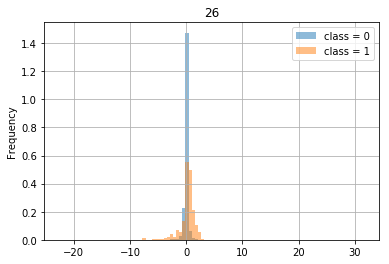

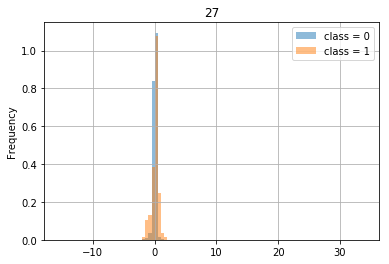

In [5]:
#plot histogram across features
for col in range(28):
  fig,axis = plt.subplots()
  bin_edges = np.linspace(pd_df.iloc[:,col].min(),pd_df.iloc[:,col].max(),100)
  pd_df.iloc[:,col][pd_df['class']==0].plot(kind='hist', density=True, ax=axis,bins=bin_edges,grid=True,alpha=0.5)
  pd_df.iloc[:,col][pd_df['class']==1].plot(kind='hist', density=True, ax=axis,bins=bin_edges,grid=True,alpha=0.5)
  #pd_df.iloc[:,col][pd_df['class']==0].plot(kind='kde', ax=axis,grid=True)
  #pd_df.iloc[:,col][pd_df['class']==1].plot(kind='kde', ax=axis,grid=True)
  plt.title(col)
  plt.legend(['class = 0','class = 1'])

### Classification using entire data
In this section, we will try to perform classification using the entire data.

We make use of the class-weight parameter to set higher weights for the anomalous data points so as to increase the true positive rate.

We will use logistic regression as the classifier, as training the other classifiers take a lot of time with such a huge dataset. But the insights we obtain here carry forward to other classifiers too.

In [0]:
x_data = cc_trans.data
y_data = cc_trans.target.astype('int')
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


class_weights =  {0: 1, 1: 1} confusion matrix = 
 [[93822    16]
 [   63    86]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


class_weights =  balanced confusion matrix = 
 [[91383  2455]
 [   12   137]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


class_weights =  {0: 1, 1: 1000} confusion matrix = 
 [[89188  4650]
 [   12   137]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


class_weights =  {0: 1, 1: 2000} confusion matrix = 
 [[84589  9249]
 [    7   142]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


class_weights =  {0: 1, 1: 5000} confusion matrix = 
 [[75412 18426]
 [    5   144]]
class_weights =  {0: 1, 1: 10000} confusion matrix = 
 [[67029 26809]
 [    2   147]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Text(0, 0.5, 'true positive rate')

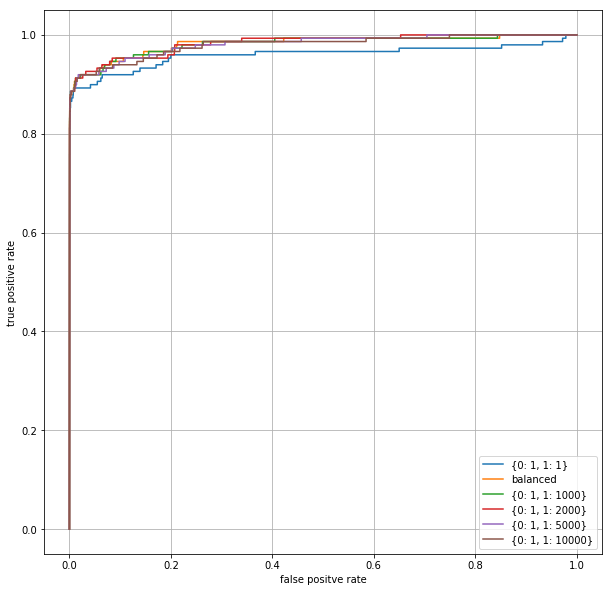

In [7]:
from sklearn.linear_model import LogisticRegression 
class_weights = [{0:1,1:1},'balanced',{0:1,1:1000},{0:1,1:2000},{0:1,1:5000},{0:1,1:10000}]
fig,axis = plt.subplots(figsize=(10,10))
for class_weight_var in class_weights:  
  LR_clf = LogisticRegression(class_weight=class_weight_var,solver='lbfgs')
  LR_clf.fit(x_train,y_train)
  y_predict_LR = LR_clf.predict(x_test)
  confu_matrix_LR = sklearn.metrics.confusion_matrix(y_test,y_predict_LR)
  y_prob_LR = LR_clf.predict_proba(x_test)
  print("class_weights = ", class_weight_var, "confusion matrix = \n", confu_matrix_LR)

  fpr, tpr, thresholds = roc_curve(y_test, y_prob_LR[:,1])
  roc_auc = auc(fpr, tpr)
  axis.plot(fpr, tpr)
plt.grid()
plt.legend(class_weights)
plt.xlabel('false positve rate')
plt.ylabel('true positive rate')

### Under-sampling

One technique to make the datasets balanced, is to undersample the samples belonging to the larger class. Under-sampling results in loss of information, but if we have sufficient samples in each class, we should be fine. Advantage of undersampling is that it helps to speed-up training, and to address the issue of in-balance in the data samples.  

Note that undersampling is done only during training. For evaluating the performance, we will need to use the true data.

In [8]:
# implement random undersampling of non-fraud data
sample_factor = 3

x_train_0 = x_train[y_train==0]
y_train_0 = y_train[y_train==0]

x_train_1 = x_train[y_train==1]
y_train_1 = y_train[y_train==1]

num_samples_0 = np.floor(sample_factor*y_train_1.size).astype('int')
print(num_samples_0, y_train_0.size )
random_indices = np.random.randint(0,y_train_0.size,num_samples_0)

x_train_0_under_sampled = x_train_0[random_indices,:]
y_train_0_under_sampled = y_train_0[random_indices]


x_data_undersampled = np.concatenate((x_train_0_under_sampled,x_train_1),axis=0)
y_data_undersampled = np.concatenate((y_train_0_under_sampled,y_train_1),axis=0)

perm = np.random.permutation(y_data_undersampled.size) # random permutation of the data.

x_data_undersampled = x_data_undersampled[perm,:]
y_data_undersampled = y_data_undersampled[perm]

print("x_data_undersampled = ",x_data_undersampled.shape, ". y_data_undersampled = ", y_data_undersampled.shape)

1029 190477
x_data_undersampled =  (1372, 29) . y_data_undersampled =  (1372,)


[[93640   198]
 [   18   131]]
[[93326   512]
 [   15   134]]
[[55714 38124]
 [    2   147]]
[[42461 51377]
 [    1   148]]
[[36268 57570]
 [    2   147]]
[[33197 60641]
 [    1   148]]


Text(0, 0.5, 'true positive rate')

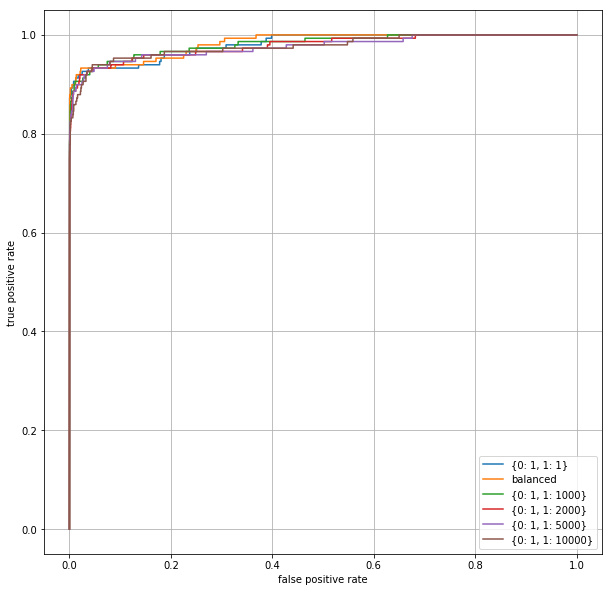

In [9]:
# train the classifiers
from  sklearn.ensemble import RandomForestClassifier
class_weights = [{0:1,1:1},'balanced',{0:1,1:1000},{0:1,1:2000},{0:1,1:5000},{0:1,1:10000}]
fig,axis = plt.subplots(figsize=(10,10))
for class_weight_var in class_weights: 
  rf_clf = RandomForestClassifier(n_estimators=200,criterion='entropy',max_depth=5,n_jobs=-1,class_weight= class_weight_var)
  rf_clf.fit(x_data_undersampled,y_data_undersampled)
  y_predict = rf_clf.predict(x_test)
  confu_matrix = sklearn.metrics.confusion_matrix(y_test,y_predict)
  y_prob = rf_clf.predict_proba(x_test)
  print(confu_matrix)

  fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr)
  
plt.grid()
plt.legend(class_weights)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

## Density Estimation

In this section we will estimate the probability density function of the non-fraud samples. Any sample with a probability density less than a threshold will be flagged as an outlier. The threshold is determined by computing the error rates for each threshold and determining the threshold as required.

In [10]:
from sklearn.neighbors import KernelDensity # import the KernelDensity class
kde_estimate = KernelDensity()
kde_estimate.fit(x_data[y_data == 0,:]) # estimate the pdf of the non-fraud datapoints using the kde methos

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [0]:
log_likelihood = kde_estimate.score_samples(x_data_undersampled) # we will restrict our attention to a smaller subset of non-fraud data as finding the pdf for each sample takes some computation time.
log_likelihood_fraud  = kde_estimate.score_samples(x_data[y_data==1,:]) # we will use entire samples of fraud data, as the number of fraud datapoints are small

min_log_likelihood_fraud = np.min(log_likelihood_fraud) #find the mininum among all log-likelihoods
max_log_likelihood_fraud = np.max(log_likelihood_fraud) #find the maximum among all log-likelihoods





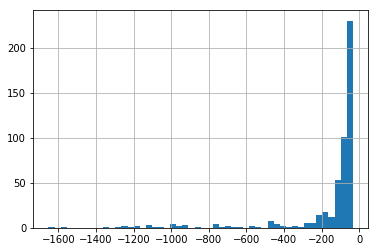

In [12]:
plt.hist(log_likelihood_fraud,bins=50) #plot the histogram of the log-likelihoods
plt.grid()

In [13]:
# Finding optimal threshold for log-likelihood via simple line search

threshold_array = []
tpr_array = []
fpr_array = []

#thresholds = np.linspace(min_log_likelihood_fraud,max_log_likelihood_fraud,100) # This gives a coarse idea of the ideal threshold.
thresholds = np.linspace(-60,-30,100) # this looks at the threshold at a finer resolution.

for threshold in thresholds:
  y_predict = np.logical_not (log_likelihood >= threshold) #Note that we are calling logical_not to toggle the class labels
  tnr = np.count_nonzero(y_predict[y_data_undersampled==0]==y_data_undersampled[y_data_undersampled==0])
  fpr = np.count_nonzero(y_predict[y_data_undersampled==0]!=y_data_undersampled[y_data_undersampled==0])
  
  tpr = np.count_nonzero(y_predict[y_data_undersampled==1]==y_data_undersampled[y_data_undersampled==1])
  fnr = np.count_nonzero(y_predict[y_data_undersampled==1]!=y_data_undersampled[y_data_undersampled==1])
  
  confu_matrix = [[tnr,fpr],[fnr,tpr]]
  print("Threshold = ", threshold, " confusion matrix = ", confu_matrix)
  threshold_array.append(threshold)
  tpr_array.append(tpr/(tpr+fnr))
  fpr_array.append(fpr/(tnr+fpr))

Threshold =  -60.0  confusion matrix =  [[1029, 0], [91, 252]]
Threshold =  -59.696969696969695  confusion matrix =  [[1029, 0], [91, 252]]
Threshold =  -59.39393939393939  confusion matrix =  [[1029, 0], [89, 254]]
Threshold =  -59.09090909090909  confusion matrix =  [[1029, 0], [87, 256]]
Threshold =  -58.78787878787879  confusion matrix =  [[1029, 0], [85, 258]]
Threshold =  -58.484848484848484  confusion matrix =  [[1029, 0], [83, 260]]
Threshold =  -58.18181818181818  confusion matrix =  [[1029, 0], [82, 261]]
Threshold =  -57.878787878787875  confusion matrix =  [[1029, 0], [81, 262]]
Threshold =  -57.57575757575758  confusion matrix =  [[1029, 0], [81, 262]]
Threshold =  -57.27272727272727  confusion matrix =  [[1029, 0], [81, 262]]
Threshold =  -56.96969696969697  confusion matrix =  [[1029, 0], [81, 262]]
Threshold =  -56.666666666666664  confusion matrix =  [[1029, 0], [81, 262]]
Threshold =  -56.36363636363636  confusion matrix =  [[1029, 0], [80, 263]]
Threshold =  -56.0606

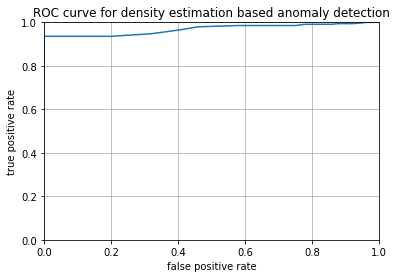

In [14]:
plt.plot(fpr_array,tpr_array)
plt.title("ROC curve for density estimation based anomaly detection")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()
plt.show()